<a href="https://colab.research.google.com/github/AdriansaWP/Belajar-Machine-Learning/blob/main/UNVR_TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving UNVR.JK.csv to UNVR.JK.csv


In [ ]:
import pandas as pd
import io
data=pd.read_csv(io.BytesIO(uploaded['UNVR.JK.csv']))
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4116 entries, 0 to 4115
Data columns (total 7 columns):
Date         4116 non-null object
Open         4056 non-null float64
High         4056 non-null float64
Low          4056 non-null float64
Close        4056 non-null float64
Adj Close    4056 non-null float64
Volume       4056 non-null float64
dtypes: float64(6), object(1)
memory usage: 225.2+ KB


<function matplotlib.pyplot.show>

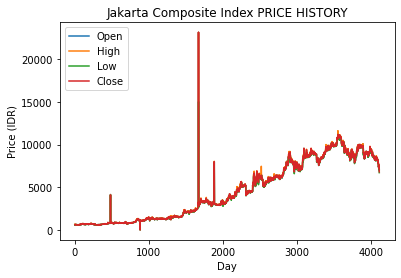

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(data['Open'])
plt.plot(data['High'])
plt.plot(data['Low'])
plt.plot(data['Close'])
plt.title("Jakarta Composite Index PRICE HISTORY")
plt.ylabel("Price (IDR)")
plt.xlabel("Day")
plt.legend(['Open','High', 'Low', 'Close'], loc="upper left")
plt.show

<function matplotlib.pyplot.show>

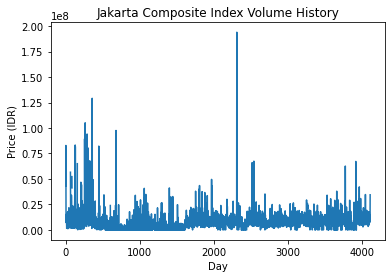

In [ ]:
plt.figure()
plt.plot(data['Volume'])
plt.title("Jakarta Composite Index Volume History")
plt.ylabel("Price (IDR)")
plt.xlabel("Day")
plt.show

In [ ]:
print("check null value (hari yg tidak ada datanya) \n", data.isna().sum())

check null value (hari yg tidak ada datanya) 
 Date          0
Open         60
High         60
Low          60
Close        60
Adj Close    60
Volume       60
dtype: int64


In [ ]:
#tidak ada data null
data = data.dropna()

In [ ]:
#normalisasi
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#train_cols = ["Open", "High", "Low", "Close", "Volume"]
train_cols = ["Close"]
data_train, data_test = train_test_split(data, train_size=0.8, test_size=0.2, shuffle=False )
print("data_train and data_test size: ", len(data_train), len(data_test))

data_train and data_test size:  3244 812


In [ ]:
#scale data min max
x = data_train.loc[:, train_cols].values  #mengambil semua atribut dalam train_cols
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(data_test.loc[:, train_cols])

x_train

array([[0.02716071],
       [0.02759459],
       [0.02781152],
       ...,
       [0.33456265],
       [0.33477959],
       [0.34671121]])

In [ ]:
import numpy as np

def build_timeseries(mat, y_col_index):
  dim_0 = mat.shape[0] - TIME_STEPS
  dim_1 = mat.shape[1]
  x = np.zeros((dim_0, TIME_STEPS, dim_1))
  y = np.zeros((dim_0,))

  for i in range(dim_0):
    x[i] = mat[i:TIME_STEPS+i]
    y[i] = mat[TIME_STEPS+i, y_col_index]
  
  print("Panjang data time series i/o", x.shape, y.shape)
  return x,y

In [ ]:
def trim_dataset(mat, batch_size):
  no_of_rows_drop = mat.shape[0]%batch_size
  if(no_of_rows_drop > 0):
    return mat[:-no_of_rows_drop]
  else:
    return mat

In [ ]:
TIME_STEPS = 30
BATCH_SIZE = 100
x_t, y_t = build_timeseries(x_train, 0)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test,0)
x_val = trim_dataset(x_temp, BATCH_SIZE)
y_val = trim_dataset(y_temp, BATCH_SIZE)

Panjang data time series i/o (3214, 30, 1) (3214,)
Panjang data time series i/o (782, 30, 1) (782,)


In [ ]:
import tensorflow as tf
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers.recurrent import LSTM #long short term memory
lstm_model = Sequential()
lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), stateful=True, kernel_initializer='random_uniform'))

lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(20, activation='relu'))
lstm_model.add(Dense(1, activation='sigmoid'))



#compile model
lstm_model.compile(loss='mean_squared_error', optimizer='RMSprop')
lstm_model.summary()

Using TensorFlow backend.



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (100, 100)                40800     
_________________________________________________________________
dropout_1 (Dropout)          (100, 100)                0         
_________________________________________________________________
dense_1 (Dense)              (100, 20)                 2020      
_________________________________________________________________
dense_2 (Dense)              (100, 1)                  21        
Total params: 42,841
Trainable params: 42,841
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#train model
nn_train = lstm_model.fit(x_t, y_t, epochs= 1000, verbose= 1, batch_size=BATCH_SIZE, shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),trim_dataset(y_val, BATCH_SIZE)))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 3200 samples, validate on 700 samples
Epoch 1/1000





3200/3200 [==============================] - 10s 3ms/step - loss: 0.0316 - val_loss: 0.0023
Epoch 2/1000
3200/3200 [==============================] - 1s 390us/step - loss: 0.0092 - val_loss: 0.0018
Epoch 3/1000
3200/3200 [==============================] - 1s 448us/step - loss: 0.0081 - val_loss: 0.0015
Epoch 4/1000
3200/3200 [==============================] - 1s 446us/step - loss: 0.0074 - val_loss: 0.0015
Epoch 5/1000
3200/3200 [==============================] - 2s 494us/step - loss: 0.0066 - val_loss: 0.0013
Epoch 6/1000
3200/3200 [==============================] - 1s 417us/step - loss: 0.0063 - val_loss: 0.0010
Epoch 7/1000
3200/3200 [==============================] - 1s 460us/step - loss: 0.0057 - val_loss: 9.0406e-04
Epoch 8/1000
3200/3200 [==============================] - 1s 451us/step - loss: 0.0053 - val_loss: 9.0115e

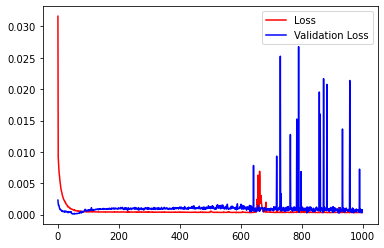

In [ ]:
loss = nn_train.history['loss']
val_loss = nn_train.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', color="red", label="Loss")
plt.plot(epochs, val_loss, 'b', color="blue", label="Validation Loss")
plt.legend()

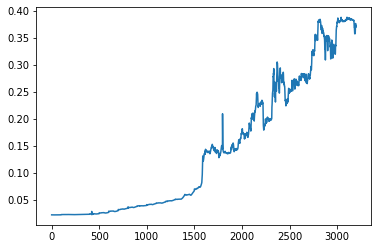

In [ ]:
ramal = lstm_model.predict(x_t, batch_size=100)
plt.plot(ramal)

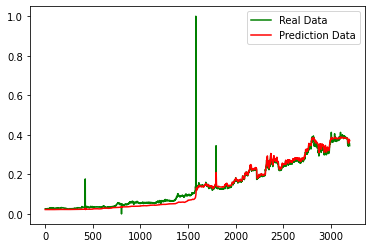

In [ ]:
plt.plot(y_t, color="green", label="Real Data")
plt.plot(ramal, color="red", label="Prediction Data")
plt.legend()

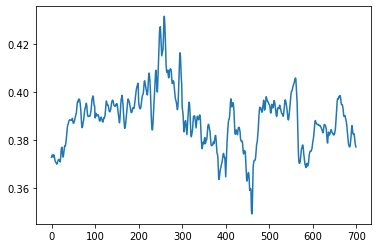

In [ ]:
ramal2 = lstm_model.predict(x_val, 100)
plt.plot(ramal2)

In [ ]:
plt.plot(y_val, color="green", label="Real Data")
plt.plot(ramal2, color="red", label="Prediction Data")
plt.legend()

NameError: ignored